This notebook will implement the CF duration measurement for whole audio recordings. Our individual call analysis showed a decreased mean CF duration. However, we can't rule out whether this decrease is coming from a methodological bias or a real effect in the data. The methodological bias is that perhaps we see a decreased CF duration because shorted calls are less  likely to be overlapped, and thus picked up more often by the individual call analysis (the individual call analysis used non-overlapping calls). 

The current analysis will overcome the problem of choosing non-overlapping calls by specifically choosing CF poritions of multiple calls in a recording. Even in multi-bat calls, the idea is to choose only calls from one bat, as distinguished by each bat's CF range. The identity of the bat is easily told by looking at a spectrogram. 

### The pipeline:

1. Load audio signal X. Generate moving average/hilbert envelope of signal 
1. Select the loudest 500 ms window in the audio. If the audio is <= 500ms, then choose the entire audio. 
1. Compute spectrum, and choose the peak frequency $\pm$ 1.5 kHz as the band of interest. 
1. Generate the time-frequency representation (TFR) of the audio (spectrogram, PWVD)
1. Select all portions of the TFR that are within the band of interest and increase above a particular threshold. These
    are the CF segments of calls.
1. Manually inspect the plausibility of the CF segments by plotting over a spectrogram of the audio (and remove wrong/poor detections)

### Some issues right now:

1. PWVD for long audio is too slow and memory intensive. Right now, one option is to use the spectrogram time-frequency representation instead to extract the CF parts of the audio.  


Notebook initiation date: 2021-07-05
Author: Thejasvi Beleyur

In [1]:
import matplotlib.pyplot as plt 
import scipy.signal as signal 
import numpy as np 
import soundfile as sf
import scipy.ndimage as ndimage 
import itsfm

In [2]:
%matplotlib notebook

In [3]:
# load the multichannel test audio with multiple examples on it. 
test_audio, fs = sf.read('../test_audio/call_alteration_testaudio.wav')

In [44]:
def get_sensible_subportion(X,min_sample, max_sample):
    '''
    '''
    start_sensible, end_sensible = min_sample>=0, max_sample<X.size
    both_sensible = np.logical_and(start_sensible, end_sensible)
    start_or_end_sensible = np.logical_or(start_sensible, end_sensible)
    
    window_size=  max_sample-min_sample
    
    if both_sensible:
        return X[min_sample:max_sample]
    if not start_or_end_sensible:
        raise IndexError(f'Both min and max samples do not make sense: {min_sample, max_sample}')
    if not start_sensible:
        return X[:window_size]
    if not end_sensible:
        
        return X[X.size-window_size:]

def choose_loudest_window(X,fs,win_durn=0.5):
    '''
    '''
    if X.size/fs >= win_durn:
        # generate hilbert envelope
        envelope = np.abs(signal.hilbert(X))
        # lowpass the envelope at 0.25xwin_durn
        max_fluctuation = 0.25*win_durn
        max_freq = 1/max_fluctuation
        b,a = signal.butter(1,max_freq/(fs*0.5),'lowpass')
        envelope_lp = signal.lfilter(b,a,envelope)

        # get loudest part and +/- 1/2 win_durn
        peak = np.argmax(envelope_lp)
        half_winsamples = int(fs*win_durn*0.5)
        return get_sensible_subportion(X, peak-half_winsamples, peak+half_winsamples)
        
    else: 
        return X   

def get_band_of_interest(X,fs,**kwargs):
    '''
    Gets main band of interest by taking the peak frequency and +/- X Hz of it
    
    Parameters
    ----------
    X : np.array
    fs : float>0
    band_halfwidth: float, optional 
        Defaults to 1,500 Hz. 

    
    Returns 
    -------
    band_of_interest: tuple
        With (min_freq, max_freq) 
    '''
    
    db_spectrum = dB(np.fft.rfft(X))
    freqs = np.fft.rfftfreq(X.size, 1/fs)
    peak_freq = freqs[np.argmax(db_spectrum)]
    half_width = kwargs.get('band_halfwidth', 1500)
    band_of_interest = (np.max([0,peak_freq-half_width]),
                        np.min([peak_freq+half_width, fs*0.5])
                        )
    return band_of_interest


def cf_detector(X,fs, band_of_interest,**kwargs):
    '''
    Parameters
    ----------
    X : np.array
    fs : float>0
    band_of_interest: array-like
        With [min_freq, max_freq] in Hz. 
    threshold: float, optional
        The threshold in dB 'pixel' value, beyond which a CF region is considered to start.
        Defaults to to -140 dB, which is 110 dB above a 'silent' pixel's value. 
        A 'silent'/non-band pixel with no signal has a typical value of -250 dB. 
    NFFT : int, optional 
        Defaults to 128 samples for FFT size
    noverlap: int, optional
        Defaults to 127 samples - FFT parameter.
    min_cf_duration : float, optional 
        Minimum duration of each CF detection. Defaults to 10ms. 

    Returns 
    -------
    filtered_cf_regions : list with slices
        Where each slice represents one CF detection of at least min_cf_duration 
        length. 
    im : np.array
        The spectrogram matrix
    '''
    # generate spectrogram
    spec,freqs,t,im = plt.specgram(X, Fs=fs, NFFT=kwargs.get('NFFT', 128),
                           noverlap=kwargs.get('noverlap',127));
    min_freq, max_freq = band_of_interest
    row_indices = np.argwhere(np.logical_and(freqs>=min_freq, freqs<=max_freq))
    # take row average of all in band frequencies
    mean_power = np.mean(spec[row_indices,:],0).flatten()
    db_meanpower = dB(mean_power)
    above_threshold = db_meanpower >= kwargs.get('threshold', -140)

    # get regions continuously above threshold
    regions_above, num_regions = ndimage.label(above_threshold)
    regions = ndimage.find_objects(regions_above)
    
    # filter detections by duration. 
    filtered_cf_regions = []
    for detection in regions:
        each = detection[0]
        duration = (each.stop - each.start)/fs
        if duration >= kwargs.get('min_cf_duration', 0.010):
            filtered_cf_regions.append(detection)
    
    return filtered_cf_regions, im
        


dB = lambda X: 20*np.log10(np.abs(X))

In [51]:
ch0 = test_audio[:,4]
ch0 = ch0[ch0!=0]
part_ch0 = choose_loudest_window(ch0,fs,win_durn=0.5)
min_freq, max_freq = get_band_of_interest(part_ch0,fs,band_halfwidth=1500)
print(min_freq, max_freq)

103460.0 106460.0


<IPython.core.display.Javascript object>


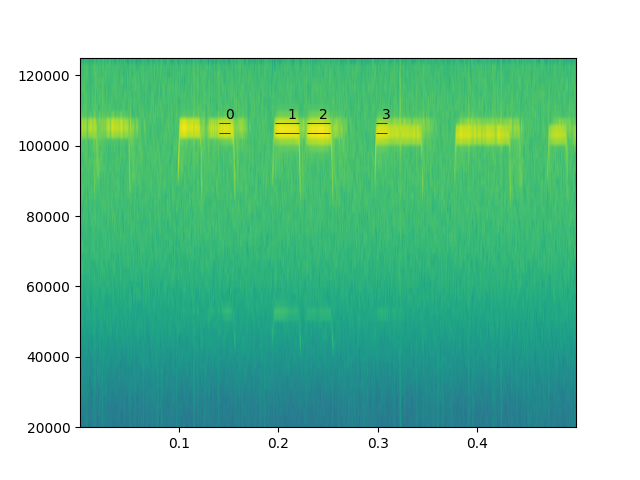

(20000.0, 125000.0)

In [53]:
cf_detns, image  = cf_detector(part_ch0, fs, band_of_interest=[min_freq, max_freq], threshold=-150);
for i,each in enumerate(cf_detns):
    plt.hlines([min_freq, max_freq], each[0].start/fs, each[0].stop/fs,linewidth=0.5,color='k')
    plt.text(np.mean([each[0].start, each[0].stop])/fs,max_freq+1000,str(i))
plt.ylim(20000, 125000)